In [1]:
import torch
from torch.autograd import Variable 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

## Let's define the LeNet network

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
            

In [3]:
net = Net()
print(net)

Net(
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)


## We'll need the MNIST data to play with. Thanks torchvision!

In [4]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
])

mnist_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_train_data_loader = DataLoader(dataset=mnist_train_dataset, batch_size=3, shuffle=True, num_workers=2)

mnist_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_test_data_loader = DataLoader(dataset=mnist_test_dataset, batch_size=3, shuffle=False, num_workers=2)

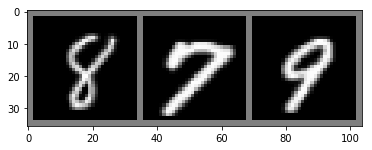

GroundTruth:      8     7     9


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2  + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
data_iter = iter(mnist_train_data_loader)
images, labels = data_iter.__next__()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(len(labels))))

## Define Objective functiona and Optimizer

In [8]:
objective_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5)

## Start the training process

In [9]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(mnist_train_data_loader, 0):
        #get the inputs
        inputs, labels = data
        
        #wrap them in Variables
        inputs, labels = Variable(inputs), Variable(labels)
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = objective_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print stats
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[EPOCH(%d), BATCH(%5d)] loss: %.3f' % (epoch + 1, i+1, running_loss/2000))
            running_loss = 0.0

print('Finished Training')

[EPOCH(1), BATCH( 2000)] loss: 2.271
[EPOCH(1), BATCH( 4000)] loss: 2.003
[EPOCH(1), BATCH( 6000)] loss: 1.453
[EPOCH(1), BATCH( 8000)] loss: 1.047
[EPOCH(1), BATCH(10000)] loss: 0.812
[EPOCH(1), BATCH(12000)] loss: 0.669
[EPOCH(1), BATCH(14000)] loss: 0.604
[EPOCH(1), BATCH(16000)] loss: 0.540
[EPOCH(1), BATCH(18000)] loss: 0.523
[EPOCH(1), BATCH(20000)] loss: 0.469
[EPOCH(2), BATCH( 2000)] loss: 0.435
[EPOCH(2), BATCH( 4000)] loss: 0.407
[EPOCH(2), BATCH( 6000)] loss: 0.397
[EPOCH(2), BATCH( 8000)] loss: 0.390
[EPOCH(2), BATCH(10000)] loss: 0.370
[EPOCH(2), BATCH(12000)] loss: 0.358
[EPOCH(2), BATCH(14000)] loss: 0.349
[EPOCH(2), BATCH(16000)] loss: 0.329
[EPOCH(2), BATCH(18000)] loss: 0.329
[EPOCH(2), BATCH(20000)] loss: 0.301
Finished Training


## Quick show of the test data and how the model does

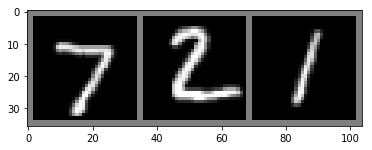

GroundTruth:      7     2     1


In [21]:
data_iter = iter(mnist_test_data_loader)
images, labels = data_iter.__next__()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(len(labels))))

In [11]:
outputs = net(Variable(images))

In [12]:
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % predicted[j] for j in range(len(labels))))

Predicted:      7     2     1


## Let's see how it does on a few batches

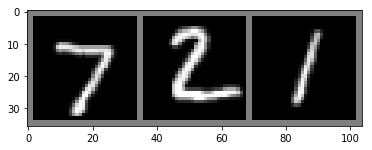

Predicted:      7     2     1


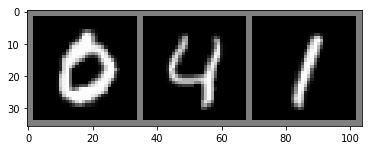

Predicted:      0     4     1


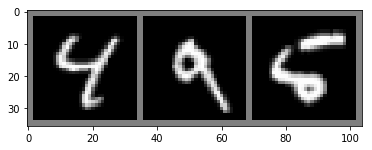

Predicted:      4     9     6


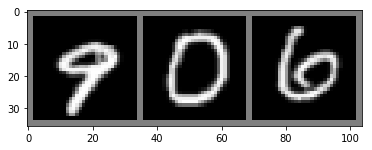

Predicted:      9     0     6


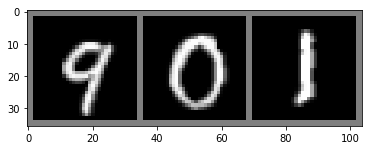

Predicted:      9     0     1


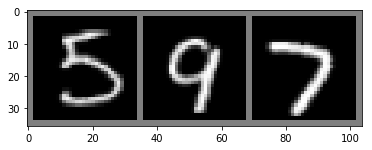

Predicted:      5     9     7


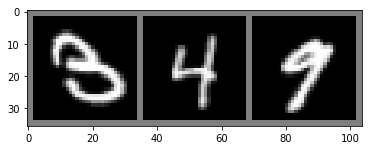

Predicted:      8     4     9


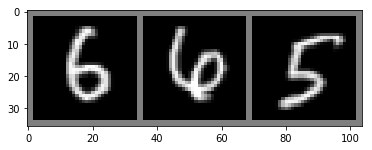

Predicted:      6     6     5


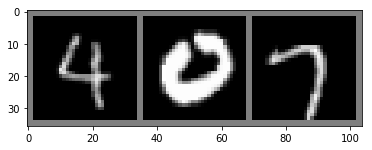

Predicted:      4     0     7


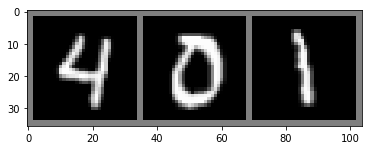

Predicted:      4     0     1
Accuracy of the network on 30 test images: 93 %


In [17]:
correct = 0
total = 0
for batch_count, data in enumerate(mnist_test_data_loader,0):
    images, labels = data
    imshow(torchvision.utils.make_grid(images))
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted: ', ' '.join('%5s' % predicted[j] for j in range(len(labels))))
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
    if batch_count == 9:
        break
    
print('Accuracy of the network on 30 test images: %d %%' % (100 * correct/total))

## Let's see what classes performed well, and the classes that did not perform well.

In [20]:
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))
for data in mnist_test_data_loader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (i+1, 100 * class_correct[i] / class_total[i]))

Accuracy of     1 : 98 %
Accuracy of     2 : 95 %
Accuracy of     3 : 92 %
Accuracy of     4 : 87 %
Accuracy of     5 : 90 %
Accuracy of     6 : 89 %
Accuracy of     7 : 92 %
Accuracy of     8 : 89 %
Accuracy of     9 : 88 %
Accuracy of    10 : 89 %
